In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [135]:
calendar = pd.read_csv("./archive/calendar.csv")
listings = pd.read_csv("./archive/listings.csv")
reviews = pd.read_csv("./archive/reviews.csv")

# INITIAL QUESTIONS
I'm going to use just the CALENDAR and LISTINGS dataset to this project.
- When is more expensive?
- Which characteristics directly affects to the price of the airbnb?
- Is there any zipcode or region more expensive?

# DATA UNDERSTANDING

CALENDAR: Dataset with availability of the airbnbs and their prices.

In [27]:
calendar.head(2)

0    $85.00
1    $85.00
Name: price, dtype: object

LISTINGS: Dataset with all the listed airbnbs and their characteristics.

In [4]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


REVIEWS: Dataset with clients' reviews. I won't use it.

In [6]:
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


# DATA PREPARATION
I will select a few interesting columns of LISTINGS due to my experience to reduce the complexity.

In [137]:
listings = listings[["id","zipcode", "host_listings_count", "latitude", "longitude", 
                    "bathrooms", "bedrooms", "beds", "bed_type", "amenities", "property_type", "room_type",
                    "square_feet", "guests_included", "extra_people", "minimum_nights", "number_of_reviews", 
                    "review_scores_rating", "reviews_per_month", "review_scores_cleanliness", "review_scores_communication", "review_scores_location",
                    "review_scores_value", "instant_bookable", "cancellation_policy", "require_guest_phone_verification",
                    "price", "weekly_price", "monthly_price"]].copy()

In [125]:
listings.head(2)

,id,zipcode,host_listings_count,bathrooms,bedrooms,beds,bed_type,amenities,property_type,room_type,...,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_phone_verification,price,weekly_price,monthly_price
0,241032,98119,3.0,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Apartment,Entire home/apt,...,10.0,10.0,9.0,10.0,f,moderate,f,$85.00,NaN,NaN
1,953595,98119,6.0,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Apartment,Entire home/apt,...,10.0,10.0,10.0,10.0,f,strict,t,$150.00,"$1,000.00","$3,000.00"


## Shapes

In [16]:
shape_cal = calendar.shape
shape_list = listings.shape

print(f"Dataset dimensions \n Calendar: {shape_cal} \n Listings: {shape_list}")

Dataset dimensions 
 Calendar: (1393570, 4) 
 Listings: (3818, 26)


## Nan

In [22]:
calendar[calendar.price.isna()]["available"].value_counts()
# Price is null when the airbnb is not available.


available
f    459028
Name: count, dtype: int64

In [28]:
# I will replace with 0.
calendar = calendar.fillna(0)
calendar.isnull().sum()

0

In [138]:
listings_nan = listings.isnull().sum()
listings_nan[listings_nan > 0].sort_values(ascending=False)
# While the dataset has len 3818, I will not use "square_feet", "monthly_price", "weekly_price"
# because those variables has so much nans.

square_feet                    3721
monthly_price                  2301
weekly_price                   1809
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
reviews_per_month               627
bathrooms                        16
zipcode                           7
bedrooms                          6
host_listings_count               2
beds                              1
property_type                     1
dtype: int64

In [139]:
listings = listings.drop(columns=["square_feet", "monthly_price", "weekly_price"])
listings_nan = listings.isnull().sum()
listings_nan[listings_nan > 0].sort_values(ascending=False)

review_scores_value            656
review_scores_location         655
review_scores_cleanliness      653
review_scores_communication    651
review_scores_rating           647
reviews_per_month              627
bathrooms                       16
zipcode                          7
bedrooms                         6
host_listings_count              2
beds                             1
property_type                    1
dtype: int64

In [140]:
# I will delete rows with nan data.
list = listings.dropna()
# I have 3136 airbnb. That's a good quantity to analize.
np.shape(list)

(3136, 26)

# When is the Airbnb more expensive?

In [141]:
calendar["date"] = pd.to_datetime(calendar["date"])
calendar["month"] = calendar["date"].dt.month
calendar["year"] = calendar["date"].dt.year
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True)
calendar["price"] = calendar["price"].astype(float)

In [142]:
price_month = calendar.groupby(['month'])['price'].mean().to_frame()

<Figure size 1200x600 with 0 Axes>

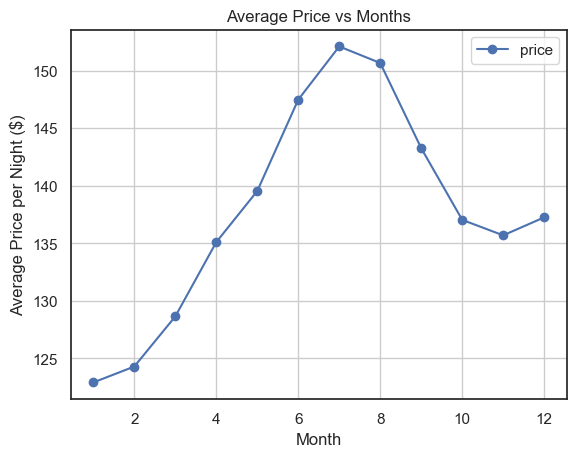

In [143]:
plt.figure(figsize=(12,6))
price_month.plot(marker='o')
plt.title('Average Price vs Months')
plt.xlabel('Month')
plt.ylabel('Average Price per Night ($)')
plt.grid(True)
plt.show()

- We can observe that the most expensive price is on summer. June, July and August are the most expensive months.  
- Christmas is the second most expensive season but the prices are reduce by half than on summer.  
- January and February are the cheapest months.

# Which characteristics directly affects to the price of the airbnb?

In [144]:
list['price'] = list['price'].replace('[\$,]', '', regex=True)
list["price"] = list["price"].astype(float)

C:\Users\jjborregueron-local\AppData\Local\Temp\ipykernel_29228\1433729906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list['price'] = list['price'].replace('[\$,]', '', regex=True)
C:\Users\jjborregueron-local\AppData\Local\Temp\ipykernel_29228\1433729906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list["price"] = list["price"].astype(float)


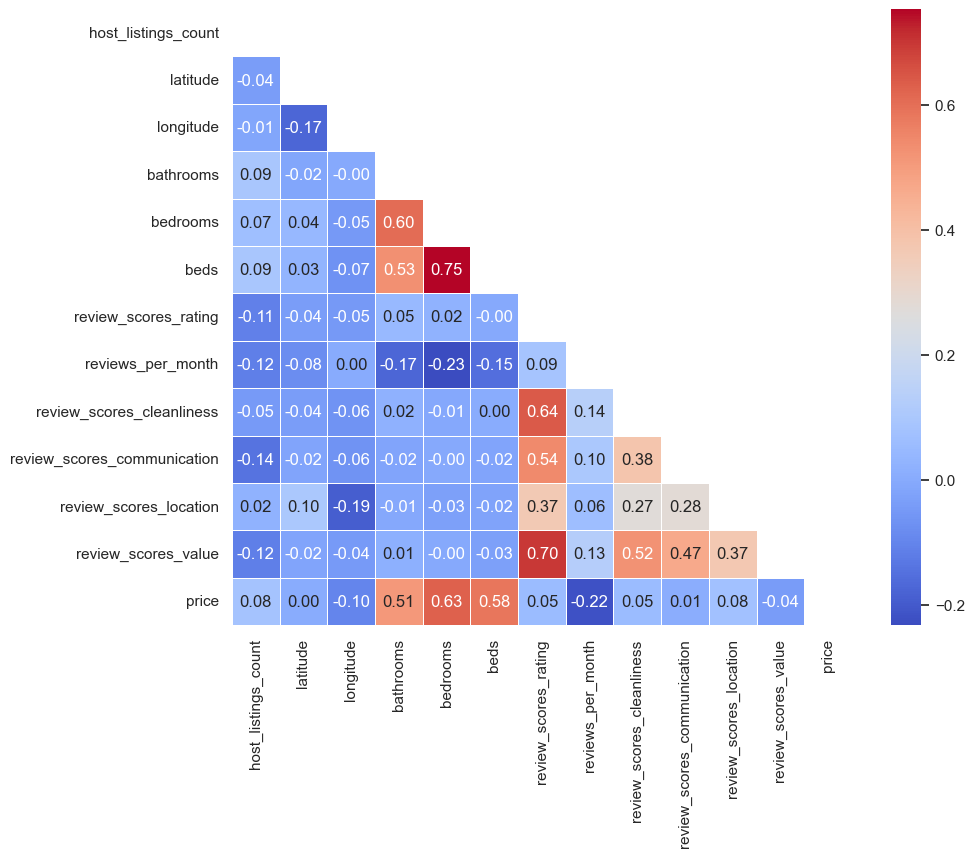

In [145]:
list_corr = list.select_dtypes(float).corr()

sns.set(style="white")
mask = np.triu(np.ones_like(list_corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(list_corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.show()

We can observe that the number ot bedrooms, bathrooms and beds are the factors that determine more directly the price of the airbnb. At first it may seem that the reviews will affect the price, but it is observed that both variables are not correlated.

# Is there any zipcode or region more expensive?

In [148]:
map_list = list[["latitude", "longitude", "price"]]

In [161]:
mapa = folium.Map(location=[map_list['latitude'].mean(), map_list['longitude'].mean()], zoom_start=10)


heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in map_list.iterrows()]
HeatMap(heat_data, max_opacity=0.6, radius=9, blur=12).add_to(mapa)

# Mostrar el mapa
mapa

It can be seen that the most expensive area is the one near downtown Seattle. To be more specific, the most expensive neighborhood is Belltown. There are streets like Hubbel Place with a fairly high price, as well as in the Union Street Substation area.